In [2]:
%pip install yfinance scikit-learn matplotlib tkan tensorflow torch


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
#modified by UNI: ap4617 


In [4]:
#In this code, I'm taking the S&P 500 dataset and preprocessing it by using the MinMaxScaler, in addition to this, 
# I'm using a lookback window of 15 as I observed that there was most variability with stocks every 15 days 
#I obtain the tensors for the Xtrain and Xtest and Ytrain and Ytest and use those values to feed into the standard KAN models 
# with various different activation functions: Bessel, Jacobi, Chebyshev and the B-spline for comparison

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tkan import TKAN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score



# Define the ticker symbol for the S&P 500 index
ticker = '^GSPC'

# Fetch historical data for the S&P 500
sp500_data = yf.download(ticker, start='2000-01-01', end='2024-12-31')
# Save the data to a CSV file
csv_file = '../sp500_data.csv'  # Example writable directory
sp500_data.to_csv(csv_file)
print(f"Data saved to {csv_file}")

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)
df = df.iloc[2:].reset_index(drop=True)
df = df.rename({'Price': 'Date'}, axis='columns')

# Extract the 'Adj Close' column as a numpy array
adj_close = df['Adj Close'].values

# Define a function to create sequences with a lookback window
def create_sequences(data, lookback=15):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])  # Lookback window
        y.append(data[i + lookback])   # Target value
    return np.array(X), np.array(y)

# Create sequences
lookback = 15
X, y = create_sequences(adj_close, lookback)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Normalize using training statistics

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()


# # Prepare data for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Check the shapes of the datasets
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

[*********************100%***********************]  1 of 1 completed

Data saved to ../sp500_data.csv
Train set: (4384, 15) (4384,)
Validation set: (939, 15) (939,)
Test set: (940, 15) (940,)


[*********************100%***********************]  1 of 1 completed


Data saved to ../sp500_data.csv
Epoch 1/20, Train Loss: 0.0147
Epoch 2/20, Train Loss: 0.0003
Epoch 3/20, Train Loss: 0.0003
Epoch 4/20, Train Loss: 0.0003
Epoch 5/20, Train Loss: 0.0002
Epoch 6/20, Train Loss: 0.0002
Epoch 7/20, Train Loss: 0.0002
Epoch 8/20, Train Loss: 0.0002
Epoch 9/20, Train Loss: 0.0002
Epoch 10/20, Train Loss: 0.0002
Epoch 11/20, Train Loss: 0.0001
Epoch 12/20, Train Loss: 0.0001
Epoch 13/20, Train Loss: 0.0001
Epoch 14/20, Train Loss: 0.0001
Epoch 15/20, Train Loss: 0.0001
Epoch 16/20, Train Loss: 0.0001
Epoch 17/20, Train Loss: 0.0001
Epoch 18/20, Train Loss: 0.0001
Epoch 19/20, Train Loss: 0.0001
Epoch 20/20, Train Loss: 0.0001
Test MSE: 0.1260, R2: -0.1567


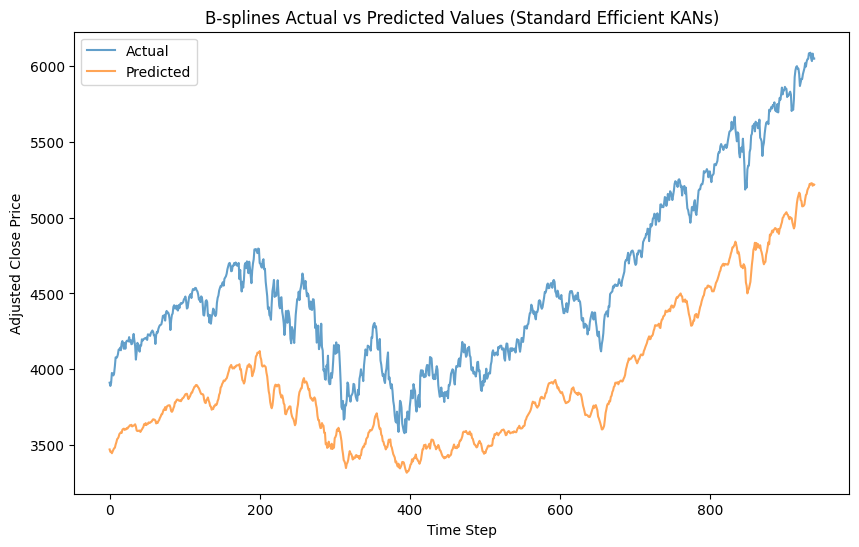

In [5]:
#Bsplines
#There are multiple parts to this code, first, we take in the S&P 500 data with focusing just a singular feature that is the AdjClose 
#next, I create the KAN efficient standard architecture with the B-spline architecture which takes in a sequence of 15 as that has been 
# set as the lookback window. Lastly, I have plotted the y_true and y_pred in order to access the performance of the model 

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import math

# Fetch historical data for the S&P 500
ticker = '^GSPC'
sp500_data = yf.download(ticker, start='2000-01-01', end='2024-12-31')

# Save the data to a CSV file
csv_file = '../sp500_data.csv'
sp500_data.to_csv(csv_file)
print(f"Data saved to {csv_file}")

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)
df = df.iloc[2:].reset_index(drop=True)
df = df.rename({'Price': 'Date'}, axis='columns')

# Extract the 'Adj Close' column as a numpy array
adj_close = df['Adj Close'].values

# Define a function to create sequences with a lookback window
def create_sequences(data, lookback=15):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])  # Lookback window
        y.append(data[i + lookback])   # Target value
    return np.array(X), np.array(y)

# Create sequences
lookback = 15
X, y = create_sequences(adj_close, lookback)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Normalize using training statistics
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

# Prepare data for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the KANLinear and KAN classes
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(
            A, B
        ).solution
        result = solution.permute(
            2, 0, 1
        )

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

# Define the model
layers_hidden = [lookback, 64, 32, 1]
kan_model = KAN(layers_hidden)
kan_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(kan_model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    kan_model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        optimizer.zero_grad()
        predictions = kan_model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

# Evaluate the model on the test set
kan_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        predictions = kan_model(X_batch)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions.squeeze().cpu().numpy())

# Rescale predictions
y_pred_rescaled = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_true_rescaled = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"Test MSE: {mse:.4f}, R2: {r2:.4f}")

# Plot predictions vs. actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_true_rescaled, label='Actual', alpha=0.7)
plt.plot(y_pred_rescaled, label='Predicted', alpha=0.7)
plt.title('B-splines Actual vs Predicted Values (Standard Efficient KANs)')
plt.xlabel('Time Step')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.savefig('../outputs/standard_bspline.png', dpi=300, bbox_inches='tight')
plt.show()

[*********************100%***********************]  1 of 1 completed


Data saved to ../sp500_data.csv
Epoch 1/20, Train Loss: 0.0101
Epoch 2/20, Train Loss: 0.0004
Epoch 3/20, Train Loss: 0.0003
Epoch 4/20, Train Loss: 0.0003
Epoch 5/20, Train Loss: 0.0003
Epoch 6/20, Train Loss: 0.0002
Epoch 7/20, Train Loss: 0.0002
Epoch 8/20, Train Loss: 0.0002
Epoch 9/20, Train Loss: 0.0002
Epoch 10/20, Train Loss: 0.0002
Epoch 11/20, Train Loss: 0.0001
Epoch 12/20, Train Loss: 0.0001
Epoch 13/20, Train Loss: 0.0001
Epoch 14/20, Train Loss: 0.0001
Epoch 15/20, Train Loss: 0.0001
Epoch 16/20, Train Loss: 0.0001
Epoch 17/20, Train Loss: 0.0001
Epoch 18/20, Train Loss: 0.0001
Epoch 19/20, Train Loss: 0.0001
Epoch 20/20, Train Loss: 0.0001
Test MSE: 0.1713, R2: -0.5718


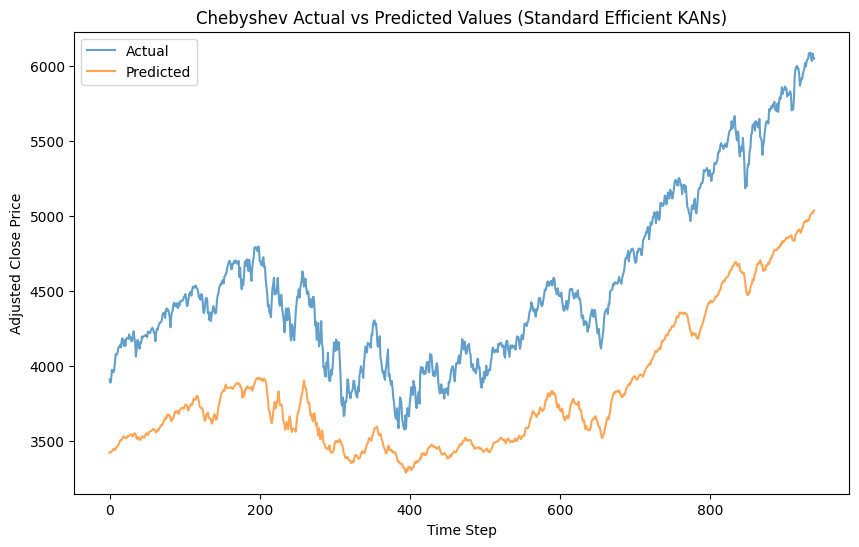

In [6]:
#Chebyshev
#There are multiple parts to this code, first, we take in the S&P 500 data with focusing just a singular feature that is the AdjClose 
#next, I create the KAN efficient standard architecture with the Chebyshev architecture which takes in a sequence of 15 as that has been 
# set as the lookback window. Lastly, I have plotted the y_true and y_pred in order to access the performance of the model 


import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import math

# Fetch historical data for the S&P 500
ticker = '^GSPC'
sp500_data = yf.download(ticker, start='2000-01-01', end='2024-12-31')

# Save the data to a CSV file
csv_file = '../sp500_data.csv'
sp500_data.to_csv(csv_file)
print(f"Data saved to {csv_file}")

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)
df = df.iloc[2:].reset_index(drop=True)
df = df.rename({'Price': 'Date'}, axis='columns')

# Extract the 'Adj Close' column as a numpy array
adj_close = df['Adj Close'].values

# Define a function to create sequences with a lookback window
def create_sequences(data, lookback=15):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])  # Lookback window
        y.append(data[i + lookback])   # Target value
    return np.array(X), np.array(y)

# Create sequences
lookback = 15
X, y = create_sequences(adj_close, lookback)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Normalize using training statistics
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
assert not np.isnan(X_train).any(), "NaN detected in normalized X_train"
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
assert not np.isnan(y_train).any(), "NaN detected in normalized y_train"
y_val = scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

# Prepare data for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the KANLinear and KAN classes
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        self.grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.chebyshev_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.chebyshev_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.chebyshev_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.chebyshev_scaler, a=math.sqrt(5) * self.scale_spline)

    def chebyshev_polynomials(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features, f"Expected x shape [batch_size, {self.in_features}], got {x.shape}"
        
        # Normalize x
        grid_diff = self.grid[:, -1] - self.grid[:, 0]
        assert not torch.any(grid_diff == 0), "Zero range detected in grid, causing division by zero."
        
        x_normalized = 2 * (x - self.grid[:, 0]) / grid_diff - 1
        x_normalized = torch.clamp(x_normalized, -1, 1)  # Clamp to prevent numerical instability
        assert not torch.isnan(x_normalized).any(), "NaN detected in x_normalized"
        T = [torch.ones_like(x_normalized), x_normalized]

        # Generate Chebyshev basis
        for n in range(2, self.grid_size + self.spline_order):
            Tn = 2 * x_normalized * T[-1] - T[-2]
            assert not torch.isnan(Tn).any(), f"NaN detected in Chebyshev term T_{n}"
            T.append(Tn)

        basis = torch.stack(T, dim=-1)  # Shape: [batch_size, in_features, grid_size + spline_order]
        #print(f"Chebyshev basis shape: {basis.shape}")
        assert basis.shape == (x.size(0), x.size(1), self.grid_size + self.spline_order), \
            f"Expected shape {(x.size(0), x.size(1), self.grid_size + self.spline_order)}, got {basis.shape}"
        return basis

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        #print(f"Input x shape: {x.shape}, y shape: {y.shape}")
        A = self.chebyshev_polynomials(x).transpose(0, 1)  # Shape: [in_features, batch_size, grid_size + spline_order]
        B = y.transpose(0, 1)  # Shape: [in_features, batch_size, out_features]
       #print(f"Polynomial basis A shape: {A.shape}, Target B shape: {B.shape}")
        
        # Solve least-squares problem
        solution = torch.linalg.lstsq(A, B).solution  # Shape: [in_features, grid_size + spline_order, out_features]
        assert not torch.isnan(solution).any(), "NaN detected in least-squares solution."
        result = solution.permute(2, 0, 1)  # Shape: [out_features, in_features, grid_size + spline_order]
        #print(f"Curve coefficients result shape: {result.shape}")

        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order), \
            f"Expected shape {(self.out_features, self.in_features, self.grid_size + self.spline_order)}, got {result.shape}"
        return result.contiguous()

    @property
    def scaled_chebyshev_weight(self):
        return self.chebyshev_weight * (
            self.chebyshev_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        chebyshev_output = F.linear(
            self.chebyshev_polynomials(x).view(x.size(0), -1),
            self.scaled_chebyshev_weight.view(self.out_features, -1),
        )
        output = base_output + chebyshev_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

# Define the model
layers_hidden = [lookback, 64, 32, 1]
kan_model = KAN(layers_hidden)
kan_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(kan_model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    kan_model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        optimizer.zero_grad()
        predictions = kan_model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

# Evaluate the model on the test set
kan_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        predictions = kan_model(X_batch)
        
        # Check for NaNs in predictions and ground truth
        if torch.isnan(predictions).any():
            print("NaN detected in predictions.")
        if torch.isnan(y_batch).any():
            print("NaN detected in ground truth.")
        
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions.squeeze().cpu().numpy())

# Rescale predictions
y_pred_rescaled = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_true_rescaled = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"Test MSE: {mse:.4f}, R2: {r2:.4f}")

# Plot predictions vs. actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_true_rescaled, label='Actual', alpha=0.7)
plt.plot(y_pred_rescaled, label='Predicted', alpha=0.7)
plt.title('Chebyshev Actual vs Predicted Values (Standard Efficient KANs)')
plt.xlabel('Time Step')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.savefig('../outputs/standard_chebyshev.png', dpi=300, bbox_inches='tight')
plt.show()

[*********************100%***********************]  1 of 1 completed


Data saved to ../sp500_data.csv
Epoch 1/20, Train Loss: 18.3535, Val Loss: 0.0133
Epoch 2/20, Train Loss: 18.3227, Val Loss: 0.0063
Epoch 3/20, Train Loss: 18.3104, Val Loss: 0.0030
Epoch 4/20, Train Loss: 18.3000, Val Loss: 0.0045
Epoch 5/20, Train Loss: 18.2901, Val Loss: 0.0035
Epoch 6/20, Train Loss: 18.2827, Val Loss: 0.0044
Epoch 7/20, Train Loss: 18.2778, Val Loss: 0.0048
Epoch 8/20, Train Loss: 18.2730, Val Loss: 0.0048
Test MSE: 0.0258, R2: 0.7635


/var/folders/jr/71_7kvq10yqdp96lxl9nzgsr0000gn/T/ipykernel_75411/2373636491.py:318: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kan_model.load_state_dict(torch.load('../be

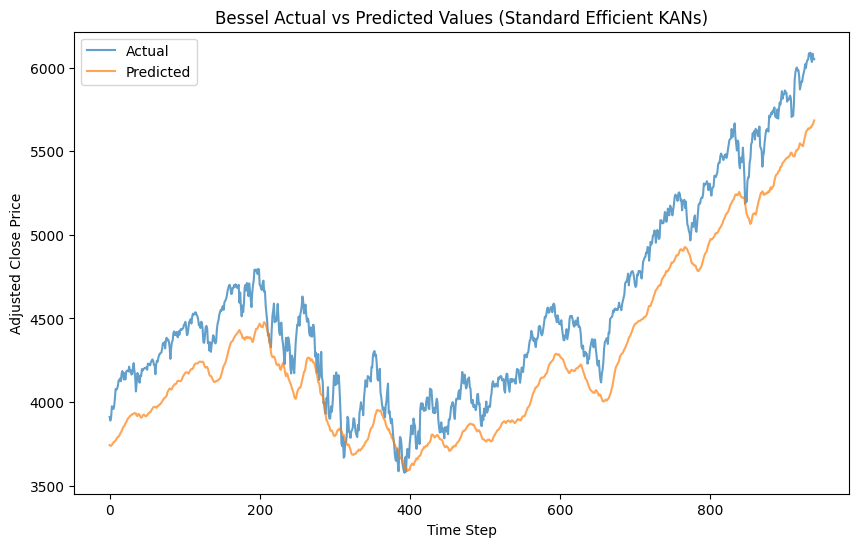

In [7]:
#Bessel
#There are multiple parts to this code, first, we take in the S&P 500 data with focusing just a singular feature that is the AdjClose 
#next, I create the KAN efficient standard architecture with the Bessel architecture which takes in a sequence of 15 as that has been 
# set as the lookback window. Lastly, I have plotted the y_true and y_pred in order to access the performance of the model 

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import math
from scipy.special import jv  # Bessel function of the first kind

# Fetch historical data for the S&P 500
ticker = '^GSPC'
sp500_data = yf.download(ticker, start='2000-01-01', end='2024-12-31')

# Save the data to a CSV file
csv_file = '../sp500_data.csv'
sp500_data.to_csv(csv_file)
print(f"Data saved to {csv_file}")

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)
df = df.iloc[2:].reset_index(drop=True)
df = df.rename({'Price': 'Date'}, axis='columns')

# Extract the 'Adj Close' column as a numpy array
adj_close = df['Adj Close'].values

# Define a function to create sequences with a lookback window
def create_sequences(data, lookback=15):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])  # Lookback window
        y.append(data[i + lookback])   # Target value
    return np.array(X), np.array(y)

# Create sequences
lookback = 15
X, y = create_sequences(adj_close, lookback)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Convert to float32 for PyTorch
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Normalize using training statistics
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

# Prepare data for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the KANLinear and KAN classes
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        self.grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bessel_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.bessel_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.bessel_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.bessel_scaler, a=math.sqrt(5) * self.scale_spline)

    def bessel_functions(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features, f"Expected x shape [batch_size, {self.in_features}], got {x.shape}"

        grid_diff = self.grid[:, -1] - self.grid[:, 0]
        assert not torch.any(grid_diff == 0), "Zero range detected in grid, causing division by zero."

        x_normalized = 2 * (x - self.grid[:, 0]) / grid_diff - 1
        x_normalized = torch.clamp(x_normalized, -1, 1)  # Clamp to prevent numerical instability
        assert not torch.isnan(x_normalized).any(), "NaN detected in x_normalized"

        J = [torch.ones_like(x_normalized)]
        for n in range(1, self.grid_size + self.spline_order):
            Jn = torch.from_numpy(jv(n, x_normalized.detach().cpu().numpy())).to(x.device)
            assert not torch.isnan(Jn).any(), f"NaN detected in Bessel function term J_{n}"
            J.append(Jn)

        basis = torch.stack(J, dim=-1)  # Shape: [batch_size, in_features, grid_size + spline_order]
        #print(f"Bessel basis shape: {basis.shape}")
        assert basis.shape == (x.size(0), x.size(1), self.grid_size + self.spline_order), \
            f"Expected shape {(x.size(0), x.size(1), self.grid_size + self.spline_order)}, got {basis.shape}"
        return basis

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        #print(f"Input x shape: {x.shape}, y shape: {y.shape}")
        A = self.bessel_functions(x).transpose(0, 1)  # Shape: [in_features, batch_size, grid_size + spline_order]
        B = y.transpose(0, 1)  # Shape: [in_features, batch_size, out_features]
        #print(f"Polynomial basis A shape: {A.shape}, Target B shape: {B.shape}")

        solution = torch.linalg.lstsq(A, B).solution  # Shape: [in_features, grid_size + spline_order, out_features]
        assert not torch.isnan(solution).any(), "NaN detected in least-squares solution."
        result = solution.permute(2, 0, 1)  # Shape: [out_features, in_features, grid_size + spline_order]
        #print(f"Curve coefficients result shape: {result.shape}")

        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order), \
            f"Expected shape {(self.out_features, self.in_features, self.grid_size + self.spline_order)}, got {result.shape}"
        return result.contiguous()

    @property
    def scaled_bessel_weight(self):
        return self.bessel_weight * (
            self.bessel_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        bessel_output = F.linear(
            self.bessel_functions(x).view(x.size(0), -1),
            self.scaled_bessel_weight.view(self.out_features, -1),
        )
        output = base_output + bessel_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output      

class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

# Define the model
layers_hidden = [lookback, 64, 32, 1]
kan_model = KAN(layers_hidden)
kan_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(kan_model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop with enhancements
epochs = 20
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 5

for epoch in range(epochs):
    kan_model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        optimizer.zero_grad()
        predictions = kan_model(X_batch)
        l2_reg = sum(param.norm(2) for param in kan_model.parameters())
        loss = criterion(predictions.squeeze(), y_batch) + 0.001 * l2_reg
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)

    kan_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            predictions = kan_model(X_batch)
            val_loss += criterion(predictions.squeeze(), y_batch).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(kan_model.state_dict(), '../best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        #print("Early stopping triggered.")
        break

    scheduler.step()

# Load the best model
kan_model.load_state_dict(torch.load('../best_model.pth'))

# Evaluate the model on the test set
y_true, y_pred = [], []
kan_model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        predictions = kan_model(X_batch)

        if torch.isnan(predictions).any():
            print("NaN detected in predictions.")
        if torch.isnan(y_batch).any():
            print("NaN detected in ground truth.")

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions.squeeze().cpu().numpy())

# Rescale predictions
y_pred_rescaled = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_true_rescaled = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"Test MSE: {mse:.4f}, R2: {r2:.4f}")

# Plot predictions vs. actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_true_rescaled, label='Actual', alpha=0.7)
plt.plot(y_pred_rescaled, label='Predicted', alpha=0.7)
plt.title('Bessel Actual vs Predicted Values (Standard Efficient KANs)')
plt.xlabel('Time Step')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.savefig('../outputs/standard_bessel.png', dpi=300, bbox_inches='tight')
plt.show()

[*********************100%***********************]  1 of 1 completed


Data saved to ../sp500_data.csv
Epoch 1/20, Train Loss: 0.1182
Epoch 2/20, Train Loss: 0.0050
Epoch 3/20, Train Loss: 0.0022
Epoch 4/20, Train Loss: 0.0022
Epoch 5/20, Train Loss: 0.0011
Epoch 6/20, Train Loss: 0.0014
Epoch 7/20, Train Loss: 0.0008
Epoch 8/20, Train Loss: 0.0007
Epoch 9/20, Train Loss: 0.0007
Epoch 10/20, Train Loss: 0.0005
Epoch 11/20, Train Loss: 0.0006
Epoch 12/20, Train Loss: 0.0008
Epoch 13/20, Train Loss: 0.0008
Epoch 14/20, Train Loss: 0.0006
Epoch 15/20, Train Loss: 0.0006
Epoch 16/20, Train Loss: 0.0007
Epoch 17/20, Train Loss: 0.0009
Epoch 18/20, Train Loss: 0.0009
Epoch 19/20, Train Loss: 0.0008
Epoch 20/20, Train Loss: 0.0005
Test MSE: 0.0054, R2: 0.8473


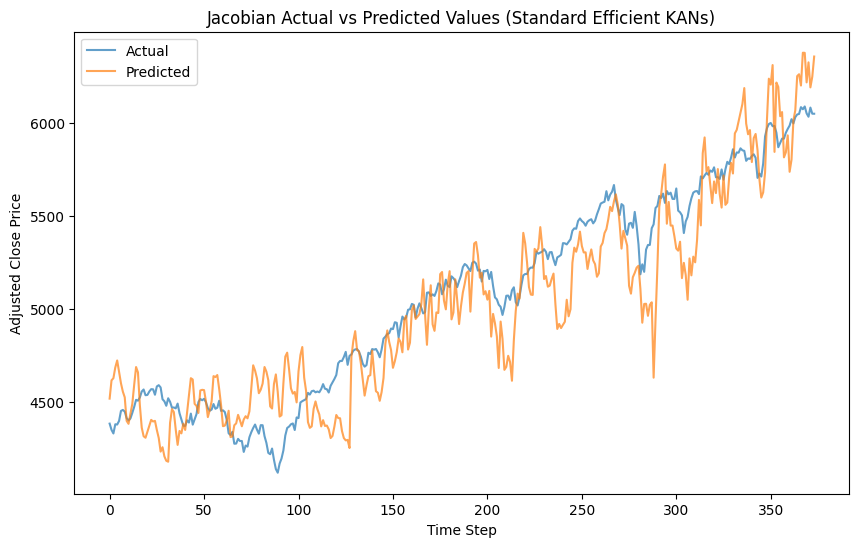

In [8]:
#Jacobi
#There are multiple parts to this code, first, we take in the S&P 500 data with focusing just a singular feature that is the AdjClose 
#next, I create the KAN efficient standard architecture with the Jacobi architecture which takes in a sequence of 15 as that has been 
# set as the lookback window. Lastly, I have plotted the y_true and y_pred in order to access the performance of the model 


import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import math

# Fetch historical data for the S&P 500
ticker = '^GSPC'
sp500_data = yf.download(ticker, start='2015-01-01', end='2024-12-31')

# Save the data to a CSV file
csv_file = '../sp500_data.csv'
sp500_data.to_csv(csv_file)
print(f"Data saved to {csv_file}")

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)
df = df.iloc[2:].reset_index(drop=True)
df = df.rename({'Price': 'Date'}, axis='columns')

# Extract the 'Adj Close' column as a numpy array
adj_close = df['Adj Close'].values

# Define a function to create sequences with a lookback window
def create_sequences(data, lookback=15):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])  # Lookback window
        y.append(data[i + lookback])   # Target value
    return np.array(X), np.array(y)

# Create sequences
lookback = 15
X, y = create_sequences(adj_close, lookback)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Normalize using training statistics
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

# Prepare data for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the KANLinear and KAN classes with Jacobi Splines
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        alpha=0.5,
        beta=0.5,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.SiLU,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.alpha = alpha
        self.beta = beta

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features * (spline_order + 1))
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = torch.empty(
                self.out_features,
                self.in_features * (self.spline_order + 1),
            ).normal_(mean=0, std=self.scale_noise)  # Normal with fixed mean/std
            self.spline_weight.data.copy_(noise)
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def jacobi_splines(self, x):
        assert x.dim() == 2 and x.size(1) == self.in_features

        P = [torch.ones_like(x), 0.5 * (2 * self.alpha + 3) * x]
        for n in range(2, self.spline_order + 1):
            Pn = (
                (2 * n + self.alpha + self.beta - 1)
                * (2 * n + self.alpha + self.beta - 2)
                * x * P[-1]
                - (n + self.alpha - 1)
                * (n + self.beta - 1)
                * (2 * n + self.alpha + self.beta)
                * P[-2]
            ) / (2 * n * (n + self.alpha + self.beta - 1))
            Pn = Pn / torch.norm(Pn, dim=0, keepdim=True)  # Normalize terms
            P.append(Pn)

        jacobi_bases = torch.stack(P, dim=-1)  # Shape: (batch_size, in_features, spline_order + 1)
        jacobi_bases = jacobi_bases.view(x.size(0), -1)  # Flatten to (batch_size, in_features * (spline_order + 1))
        return jacobi_bases

    def forward(self, x):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.jacobi_splines(x), self.spline_weight
        )
        output = base_output + spline_output
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

class KAN(nn.Module):
    def __init__(self, layers_hidden, **kwargs):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList(
            KANLinear(in_f, out_f, **kwargs)
            for in_f, out_f in zip(layers_hidden, layers_hidden[1:])
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define the model
layers_hidden = [lookback, 64, 32, 1]
kan_model = KAN(layers_hidden, grid_size=5, spline_order=3, alpha=0.5, beta=0.5)
kan_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Training and evaluation logic remains unchanged

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(kan_model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    kan_model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        optimizer.zero_grad()
        predictions = kan_model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

# Evaluate the model on the test set
y_true, y_pred = [], []
kan_model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        predictions = kan_model(X_batch)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions.squeeze().cpu().numpy())

# Rescale predictions
y_pred_rescaled = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_true_rescaled = y_scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"Test MSE: {mse:.4f}, R2: {r2:.4f}")

# Plot predictions vs. actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_true_rescaled, label='Actual', alpha=0.7)
plt.plot(y_pred_rescaled, label='Predicted', alpha=0.7)
plt.title('Jacobian Actual vs Predicted Values (Standard Efficient KANs)')
plt.xlabel('Time Step')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.savefig('../outputs/standard_jacobian.png', dpi=300, bbox_inches='tight')
plt.show()